In [1]:
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib

sys.path.append('C:\\Users\\kpandit\\PICASSO\\picasso\\')
import mine
importlib.reload(mine)
# import os
# os.environ['CUDA_LAUNCH_BLOCKING']='1'


<module 'mine' from 'C:\\Users\\kpandit\\PICASSO\\picasso\\mine.py'>

Based off of https://github.com/gtegner/mine-pytorch

NOT ACTUALLY WHAT I NEED TO DO 
Cross entropy loss between decoded and sink is used to measure error rate in classifying a pixel from decoded as a pixel value in the sink image

I dont know what the value in the sink image is

What PICASSO does is minimizes the mutual information between (source, sink-decoded) where decoded is the mixing_parameter*source 

I need to use the mutual information loss between (source, sink-decoded) and maximize the mutual information between (encoded, source) to force a minimal representation of the source


In [8]:
class GaussianLayer(nn.Module):
    def __init__(self, std, device):
        super().__init__()
        self.std = std
        self.device = device

    def forward(self, x):
        return x + self.std * torch.randn_like(x).to(self.device)
    
    
# For MINE
class StatisticsNetwork(nn.Module):
    def __init__(self, device, noise=[0.3, 0.5, 0.5]):
        super().__init__()
        self.layers = nn.Sequential(
            GaussianLayer(std=noise[0], device=device),
            nn.Linear(2, 256),
            nn.ELU(),
            GaussianLayer(std=noise[1], device=device),
            nn.Linear(256, 256),
            nn.ELU(),
            GaussianLayer(std=noise[2], device=device),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        return self.layers(x)

    
class InformationBottlneck(nn.Module):
    def __init__(self, n_px, px_bit_depth=12, mi_estimator=None, beta=1.0):

        super().__init__()
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
            
        self.C = 2**px_bit_depth-1 # Number of classes 
        self.n_source = 1
        self.n_sink = 1
        
        self.encoder = nn.Sequential(
            nn.Linear(1, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256,1),
            nn.Softplus()
        )
        self.encoder.to(self.device)
        # map K dimensions (sink channels) to logits of C classes (pixel value???)
        
        self.decoder = nn.Sequential(
            nn.Linear(1, self.C)
            #nn.Softmax()
        )
        self.decoder.to(self.device)
        
        self.ce_loss = nn.CrossEntropyLoss()
        self.mi_estimator = mine.MINE()
        self.mi_loss_weight = beta
        
        
    def forward(self, xy):
        
        xy = xy/self.C
        source, sink = xy.chunk(2,dim=1)
    
        # additive noise encoder
        sigma = self.encoder(source)
        noise = torch.randn_like(sigma)
        encoded = source + sigma*noise #z
        
        decoded = self.decoder(encoded)
        sink = sink.long().squeeze()
#         deoded = decoded.long()
        ce_loss = self.ce_loss(decoded, target=sink)
        xy = torch.stack([source/self.C, encoded],1).squeeze()
        mi_loss = self.mi_estimator.forward(xy)

        loss = ce_loss + self.mi_loss_weight * mi_loss
        
        return decoded, loss
    
    def train_loop(self, source, sink, max_iter=100, batch_size=100, opt=None):

        #source = source.type(torch.float32)
        #sink = sink.type(torch.float32)
        old_param = self.flatten_parameters()

        if opt is None:
            opt = torch.optim.Adam(self.parameters(), lr=1e-4)
         
        loss_ = []
        for i in range(1, max_iter + 1):
            batch_loss = 0
            for batch, xy in enumerate(DataLoader(torch.stack([source, sink],1), 
                                                  batch_size, 
                                                  shuffle=True)):
                opt.zero_grad()
                decoded, loss = self.forward(xy)
                batch_loss += loss.item()
                loss.backward()
                opt.step()

            loss_.append(batch_loss/(batch+1))

            new_param = self.flatten_parameters()
            param_norm = torch.linalg.norm(new_param - old_param)
            old_param = new_param

            if i % (max_iter // 4) == 0:
                print(f"It {i} - loss: {loss_[-1]}")

            if param_norm.item() < 0.05:
                print(f"Converged in {i} iterations")
                break

        return decoded

    def flatten_parameters(self):

        p = torch.tensor([],device=self.device)

        for param in self.parameters():
             p = torch.cat([p, param.data.flatten()])

        return p

Make test data set. Bit depth = 12.


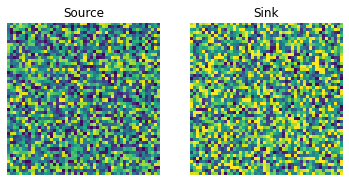

In [4]:
import matplotlib.pyplot as plt

px_size = 50
mixing_parameter = 0.25
spill_cut = 3000

# Source fluorescence
source = torch.randint(low=90, high=2**12-1, size=(px_size,px_size), dtype=torch.int16)
# Spillover fluorescence (sink)
bg = torch.randint(low=100, high=135, size=(px_size,px_size), dtype=torch.int16)  # background
signal = torch.randint(low=1000, high=2**12-1, size=(px_size,px_size), dtype=torch.int16) #signal
spill = mixing_parameter*source[[source > spill_cut]]           # spillover
spill = spill.type(torch.int16)

sink = torch.zeros_like(source)
sink[[source > spill_cut]] = spill
sink = bg + signal + sink
sink = sink.clamp(max=4095)


fig, axs = plt.subplots(1,2)
axs[0].imshow(source)
axs[0].set_title('Source')
axs[0].axis('off')
axs[1].imshow(sink)
axs[1].set_title('Sink')
axs[1].axis('off')
            
plt.show()

source = source.flatten()
#source = source.flatten().long()
#source = source.unsqueeze(dim=0)
sink = sink.flatten()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
source = source.to(device)
sink = sink.to(device)

In [5]:
model = PICASSOnn(50)
model.train_loop(source,sink)

Using cuda
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded t

decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size(

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size(

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size(

encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size(

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size(

encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size(

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size(

xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 

encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size(

encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size(

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size(

xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 

encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size(

xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size(

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size(

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size(

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size(

source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([100, 1])
decoded torch.Size([100, 4095])
sink torch.Size([100])
xy torch.Size([100, 2])
source torch.Size([100, 1])
encoded torch.Size([

tensor([[-0.6969, -0.2919, -1.0288,  ..., -0.8949, -1.1364, -0.0031],
        [-0.7761, -0.2989, -1.1371,  ..., -0.9768, -1.1400,  0.0335],
        [-0.6332, -0.2862, -0.9415,  ..., -0.8289, -1.1335, -0.0326],
        ...,
        [-0.6670, -0.2892, -0.9877,  ..., -0.8638, -1.1351, -0.0170],
        [-0.7970, -0.3007, -1.1658,  ..., -0.9985, -1.1409,  0.0432],
        [-0.5881, -0.2822, -0.8798,  ..., -0.7822, -1.1315, -0.0535]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [48]:
mine_model = mine.MINE()
mine_model.train_loop(source/4095, sink/4095)

Using cuda
It 25 - MI: 0.022166907787322998
It 50 - MI: 0.048149813711643216
It 75 - MI: 0.04641714841127396
It 100 - MI: 0.06164964735507965


[0.0003242984414100647,
 0.002125588059425354,
 0.003881068527698517,
 0.00572616308927536,
 0.006822234392166138,
 0.007528424263000488,
 0.008724752068519592,
 0.009091569483280182,
 0.010560917854309081,
 0.010901655256748199,
 0.012447088956832886,
 0.014902603626251221,
 0.015202221274375916,
 0.016042913496494293,
 0.014406836032867432,
 0.018908579647541047,
 0.019369812309741975,
 0.020636720955371855,
 0.016743758320808412,
 0.022120752930641176,
 0.027744790911674498,
 0.024961893260478974,
 0.02314547449350357,
 0.029185257107019424,
 0.022166907787322998,
 0.030730126798152922,
 0.032436756789684294,
 0.02600672170519829,
 0.027531705796718597,
 0.027830862253904343,
 0.03452048450708389,
 0.03456462845206261,
 0.03131004050374031,
 0.028493595123291016,
 0.030197343975305557,
 0.0301920048892498,
 0.03113687038421631,
 0.03566556721925736,
 0.03780873343348503,
 0.03644655719399452,
 0.03690449148416519,
 0.03475422188639641,
 0.03961566984653473,
 0.03623472601175308,
 0.

In [37]:
xy = torch.stack([source/8, sink/8], dim=1)
# t = mine_model.T(xy)
# print(t)
# torch.mean(torch.exp(t))

In [ ]:
print('source', source.shape)
loss = nn.CrossEntropyLoss()
K = 10 # bottleneck size, I think it should be equal to the batch size
in_dim = 1 #
out_dim = 4095

sigma_nn = nn.Linear(in_dim, in_dim)
sigma_nn.to('cuda')

encoder = nn.Sequential(
    nn.Linear(in_dim, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, K),
    nn.Softplus()
)
encoder.to('cuda')

decoder = nn.Sequential(
    nn.Linear(K, 100),
    #nn.Softmax()
)
decoder.to('cuda')


sigma = sigma_nn(source.float())
print('sigma', sigma.shape)
noise = torch.randn_like(sigma)
encoded = encoder(source + sigma*noise) #z
print('encoded', encoded.shape)
decoded = decoder(encoded)
print('decoded', decoded.type())
print('source', source.shape)

target = torch.tensor([3],dtype=torch.long, device='cuda')


# a = torch.tensor([[0, 1, 0],[1, 0, 0], [0, 0, 1],[0,1,0]],dtype=torch.float)
# #a = a.softmax(dim=1)
# b = torch.tensor([0,2,1,0],dtype=torch.long)
# print(a.shape)
# print(b.shape)
loss(decoded,target = target)

In [ ]:
a = torch.tensor([[0, 1, 0],[1, 0, 0], [0, 0, 1],[0,1,0]],dtype=torch.float)
#a = a.softmax(dim=1)
b = torch.tensor([0,2,1,0],dtype=torch.long)
print(a.shape)
print(b.shape)
loss(a,target = b)

In [17]:
import math
math.exp(4095/8)

2.0159879143435017e+222